In [ ]:
# Generating segmentation images for testing model

In [ ]:
import torch
import torchvision
import os
import glob
import time 
import pickle

import skimage.transform as st
import cv2 as cv
from PIL import Image

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, roc_curve, auc, accuracy_score
import seaborn as sns

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[0], device_type='GPU')

In [ ]:
import torch
torch.cuda.empty_cache()

# class data

In [ ]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, origin_mask_list, origins_folder, masks_folder, transforms=None):
        self.origin_mask_list = origin_mask_list
        self.origins_folder = origins_folder
        self.masks_folder = masks_folder
        self.transforms = transforms
    
    def __getitem__(self, idx):
        origin_name, mask_name = self.origin_mask_list[idx]
        origin = Image.open(self.origins_folder / (origin_name + ".png")).convert("P")
        mask = Image.open(self.masks_folder / (mask_name + ".png"))
        if self.transforms is not None:
            origin, mask = self.transforms((origin, mask))
            
        origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    
        mask = np.array(mask)
        mask = (torch.tensor(mask) > 128).long() 
        return origin, mask
        
    
    def __len__(self):
        return len(self.origin_mask_list)

    
class Pad():
    def __init__(self, max_padding):
        self.max_padding = max_padding
        
    def __call__(self, sample):
        origin, mask = sample
        padding = np.random.randint(0, self.max_padding)
#         origin = torchvision.transforms.functional.pad(origin, padding=padding, padding_mode="symmetric")
        origin = torchvision.transforms.functional.pad(origin, padding=padding, fill=0)
        mask = torchvision.transforms.functional.pad(mask, padding=padding, fill=0)
        return origin, mask


class Crop():
    def __init__(self, max_shift):
        self.max_shift = max_shift
        
    def __call__(self, sample):
        origin, mask = sample
        tl_shift = np.random.randint(0, self.max_shift)
        br_shift = np.random.randint(0, self.max_shift)
        origin_w, origin_h = origin.size
        crop_w = origin_w - tl_shift - br_shift
        crop_h = origin_h - tl_shift - br_shift
        
        origin = torchvision.transforms.functional.crop(origin, tl_shift, tl_shift,
                                                        crop_h, crop_w)
        mask = torchvision.transforms.functional.crop(mask, tl_shift, tl_shift,
                                                        crop_h, crop_w)
        return origin, mask


class Resize():
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, sample):
        origin, mask = sample
        origin = torchvision.transforms.functional.resize(origin, self.output_size)
        mask = torchvision.transforms.functional.resize(mask, self.output_size)
        
        return origin, mask


def blend(origin, mask1=None, mask2=None, mask3=None):
    img = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
    if mask1 is not None:
        mask1 = torchvision.transforms.functional.to_pil_image(torch.cat([
            torch.zeros_like(origin),
            torch.stack([mask1.float()]),
            torch.zeros_like(origin)
        ]))
        img = Image.blend(img, mask1, 0.2)
        
    if mask2 is not None:
        mask2 = torchvision.transforms.functional.to_pil_image(torch.cat([
            torch.stack([mask2.float()]),
            torch.zeros_like(origin),
            torch.zeros_like(origin)
        ]))
        img = Image.blend(img, mask2, 0.2)

    if mask3 is not None:
        mask3 = torchvision.transforms.functional.to_pil_image(torch.cat([
            torch.zeros_like(origin),
            torch.stack([mask3.float()]),
            torch.zeros_like(origin)
        ]))
        img = mask3

    return img

# class model

In [ ]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=mid_channel, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, padding=1)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn1 = torch.nn.BatchNorm2d(mid_channel)
            self.bn2 = torch.nn.BatchNorm2d(out_channels)
            
    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = torch.nn.functional.relu(x, inplace=True)
        
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        out = torch.nn.functional.relu(x, inplace=True)
        return out
    

class UNet(torch.nn.Module):
    def up(self, x, size):
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)
    
    def down(self, x):
        return torch.nn.functional.max_pool2d(x, kernel_size=2)
    
    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode
        
        self.enc1 = Block(in_channels, 64, 64, batch_norm)
        self.enc2 = Block(64, 128, 128, batch_norm)
        self.enc3 = Block(128, 256, 256, batch_norm)
        self.enc4 = Block(256, 512, 512, batch_norm)
        
        self.center = Block(512, 1024, 512, batch_norm)
        
        self.dec4 = Block(1024, 512, 256, batch_norm)
        self.dec3 = Block(512, 256, 128, batch_norm)
        self.dec2 = Block(256, 128, 64, batch_norm)
        self.dec1 = Block(128, 64, 64, batch_norm)
        
        self.out = torch.nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.down(enc1))
        enc3 = self.enc3(self.down(enc2))
        enc4 = self.enc4(self.down(enc3))
        
        center = self.center(self.down(enc4))
        
        dec4 = self.dec4(torch.cat([self.up(center, enc4.size()[-2:]), enc4], 1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))
        
        out = self.out(dec1)
        
        return out
    

class PretrainedUNet(torch.nn.Module):
    def up(self, x, size):
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)
    
    def down(self, x):
        return torch.nn.functional.max_pool2d(x, kernel_size=2)
    
    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode
        
        self.init_conv = torch.nn.Conv2d(in_channels, 3, 1)
        
        endcoder = torchvision.models.vgg11(pretrained=True).features
        self.conv1 = endcoder[0]   # 64
        self.conv2 = endcoder[3]   # 128
        self.conv3 = endcoder[6]   # 256
        self.conv3s = endcoder[8]  # 256
        self.conv4 = endcoder[11]   # 512
        self.conv4s = endcoder[13]  # 512
        self.conv5 = endcoder[16]  # 512
        self.conv5s = endcoder[18] # 512
    
        self.center = Block(512, 512, 256, batch_norm)
        
        self.dec5 = Block(512 + 256, 512, 256, batch_norm)
        self.dec4 = Block(512 + 256, 512, 128, batch_norm)
        self.dec3 = Block(256 + 128, 256, 64, batch_norm)
        self.dec2 = Block(128 + 64, 128, 32, batch_norm)
        self.dec1 = Block(64 + 32, 64, 32, batch_norm)
        
        self.out = torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1)

    def forward(self, x):  
        init_conv = torch.nn.functional.relu(self.init_conv(x), inplace=True)

        enc1 = torch.nn.functional.relu(self.conv1(init_conv), inplace=True)
        enc2 = torch.nn.functional.relu(self.conv2(self.down(enc1)), inplace=True)
        enc3 = torch.nn.functional.relu(self.conv3(self.down(enc2)), inplace=True)
        enc3 = torch.nn.functional.relu(self.conv3s(enc3), inplace=True)
        enc4 = torch.nn.functional.relu(self.conv4(self.down(enc3)), inplace=True)
        enc4 = torch.nn.functional.relu(self.conv4s(enc4), inplace=True)
        enc5 = torch.nn.functional.relu(self.conv5(self.down(enc4)), inplace=True)
        enc5 = torch.nn.functional.relu(self.conv5s(enc5), inplace=True)
        
        center = self.center(self.down(enc5))
        
        dec5 = self.dec5(torch.cat([self.up(center, enc5.size()[-2:]), enc5], 1))
        dec4 = self.dec4(torch.cat([self.up(dec5, enc4.size()[-2:]), enc4], 1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))
        
        out = self.out(dec1)
        
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

In [ ]:
torch.cuda.device_count()
cuda0 = torch.cuda.set_device(0)
torch.cuda.current_device() 

0

In [ ]:
model_name = "unet-6v.pt"

unet.load_state_dict(torch.load(model_name, map_location=torch.device("cpu")), strict=False)

device = torch.cuda.set_device(0)
unet.to(device)
unet.eval();

In [ ]:
def transform(img, lung=True):
  origin = torchvision.transforms.functional.resize(img, (512, 512))
  origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

  return masked(origin, lung, out)

In [ ]:
def masked(origin, lung=True, out=None):
  color = (0, 0, 0)
  masked_img = np.array(blend(origin))
  masked_part = np.array(blend(origin, mask3=out))
  for x in range(masked_img.shape[0]):
      for y in range(masked_img.shape[1]):
          r, g, b = masked_part[y][x]
          if (lung == True and (r,g,b) == color):
            masked_img[y][x] = 0
          elif lung == False and (r,g,b) != color:
            masked_img[y][x] = 0
  return masked_img

# Plot example image

In [ ]:
filename = '../TFrecords/mimic-tf-record9.tfrecords'
raw_dataset = tf.data.TFRecordDataset(filename)
for raw_record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy()) 

    ethnicity = example.features.feature['ethnicity'].int64_list.value[0]
    subject_id = example.features.feature['subject_id'].int64_list.value[0]
    nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
    img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
    img_np = Image.fromarray(img_np).convert("P")
    transformed_bg = transform(img_np, lung=False)
    transformed_lung = transform(img_np, lung=True)
    gray_image_bg = cv.cvtColor(transformed_bg, cv.COLOR_BGR2GRAY)
    gray_image_lung = cv.cvtColor(transformed_lung, cv.COLOR_BGR2GRAY)
    break

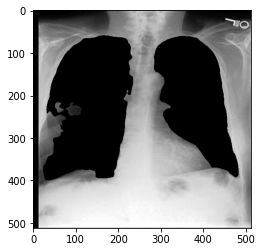

In [ ]:
plt.imshow(gray_image_bg, cmap='gray')

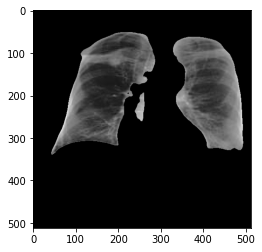

In [ ]:
plt.imshow(gray_image_lung, cmap='gray')

# Test

In [ ]:
INPUT_SHAPE = (224, 224, 1)
X_test = []
X_test_bg = []
y_test = []
filename = 'mimic_test.tfrecords'
raw_dataset = tf.data.TFRecordDataset(filename)
for raw_record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy()) 
    ethnicity = example.features.feature['ethnicity'].int64_list.value[0]
    if (ethnicity == 0):
      sub_y = [1, 0, 0]
    elif (ethnicity == 1):
      sub_y = [0, 1, 0]
    elif (ethnicity == 4):
      sub_y = [0, 0, 1]
    else:
      continue
    nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
    img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
    img_np = Image.fromarray(img_np).convert("P")

    transformed_bg = transform(img_np, lung=False)
    transformed = transform(img_np, lung=True)
    
    gray_image_bg = cv.cvtColor(transformed_bg, cv.COLOR_BGR2GRAY)
    gray_image = cv.cvtColor(transformed, cv.COLOR_BGR2GRAY)
    
    image_bg = np.float16(st.resize(gray_image_bg, INPUT_SHAPE))
    image = np.float16(st.resize(gray_image, INPUT_SHAPE))

    X_test_bg.append(np.float16(image_bg))
    X_test.append(np.float16(image))

    y_test.append(sub_y)

    del sub_y
    del img_np

X_test = np.array(X_test)
X_test_bg = np.array(X_test_bg)
y_test = np.array(y_test)